In [1]:
%matplotlib notebook

In [2]:
import pyspark

sc = pyspark.sql.SparkSession.Builder().getOrCreate()

## Levanto los archivos

In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from IPython.display import display, HTML
import math


## Utils

In [4]:
def distance(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)

def flatten_list(l):
    return [item for sublist in l for item in sublist]


def get_emission_means(row):
    sums = [0,0,0,0]
    total = [0,0,0,0]
    for em in row:
        for antenna in range(4):
            power = em[antenna]
            if power != 0:
                sums[antenna] += power
                total[antenna] += 1
    
    means = []
    for antenna in range(4):
        means.append(sums[antenna]/total[antenna] if total[antenna]>0 else 0)
    return means


def k_cross_validation(clf, data, target, get_predictor_mae, k=5):
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    if not isinstance(target, np.ndarray):
        target = np.array(target)
        
    kf = KFold(n_splits=k, shuffle=True)
    mae_list = []
    mae_list_train = []
    for train_index, test_index in kf.split(data):
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = target[train_index], target[test_index]
        
        X_train = np.array([get_emission_means(X_train[i]) for i in range(len(X_train))])
    
        y_test = np.array(flatten_list([[y_test[i]]*len(X_test[i]) for i in range(len(y_test))]))
        X_test = np.array([e for i in range(len(X_test)) for e in X_test[i]])

        clf.fit(X_train, y_train)
        mae = get_predictor_mae(clf.predict(X_test), y_test)
        mae_train = get_predictor_mae(clf.predict(X_train), y_train)
        mae_list.append(mae)
        mae_list_train.append(mae_train)

    #print('mean absolute error on test set {}'.format(mae_list))
    #print('mean absolute error on train set {}'.format(mae_list_train))
    return mae_list, mae_list_train


def show_best_results(results, estimator_name, n=5):
    best_res = sc.sparkContext.parallelize(results).sortBy(lambda x: x['error']).take(n)
    df = pd.DataFrame(list(map(lambda x: x['params'], best_res)))
    df["mean_score_validation"] = list(map(lambda x: x['error'], best_res))
    df["mean_score_training"] = list(map(lambda x: x['error_train'], best_res))
    display(HTML("<h3> {}: top {} combinaciones  </h3>".format(estimator_name, n)))
    display(df.sort_values(by="mean_score_validation", ascending=True).head(n))
    
def regre_grid_search(predictor, params, regre_data, regre_target):
    results = []
    for params in ParameterGrid(params):
        clf = MultiOutputRegressor(predictor(**params))
        res_test, res_train = k_cross_validation(clf, regre_data, regre_target, get_regressor_mae)
        results.append({'params': params, 'error': np.mean(res_test), 'error_train': np.mean(res_train)})

    show_best_results(results, predictor.__name__)
    
def classi_grid_search(predictor, params, classi_data, classi_target):
    results = []
    for params in ParameterGrid(params):
        clf = predictor(**params)
        res_test, res_train = k_cross_validation(clf, classi_data, np.array(classi_target).ravel(), get_classifier_mae)
        results.append({'params': params, 'error': np.mean(res_test), 'error_train': np.mean(res_train)})

    show_best_results(results, predictor.__name__)
    


## Maps utils

In [5]:
global posicion_antenas
posicion_antenas = [(463512.015195402,6111004.324434620),(464259.981343845,6110331.85100085),(464443.295130103,6111377.26171875),(464629.562194595,6111105.34734669)]

global x_0
global y_0

x_0 = 462385.503783397
x_f = 465958.114906211
y_0 = 6109042.35153865
y_f = 6112715.80637111


def normalize_positions(row):
    row['x'] = row['x']-x_0
    row['y'] = row['y']-y_0
    return row


In [6]:
global points_recep
points_recep = sc.read.json('datos/points-recep-with-zeros.jsonlines/').rdd

### Saco puntos que no hayan tenido ninguna recepcion

In [7]:
points_recep = points_recep.filter(lambda x: any(x['recep_0']+x['recep_1']+x['recep_2']+x['recep_3']))

### Me quedo con una sola emision por punto

In [8]:
unique_points = points_recep.groupBy(lambda x: x['Punto']).map(lambda x: list(x[1])[0])

In [24]:
def group_emisions(data):
    data_dict = data.asDict()
    recep_0 = data_dict.pop('recep_0')
    recep_1 = data_dict.pop('recep_1')
    recep_2 = data_dict.pop('recep_2')
    recep_3 = data_dict.pop('recep_3')
    
    data_dict['emissions'] = []
    for i in range(24):
        l = [recep_0[i], recep_1[i], recep_2[i], recep_3[i]]
        if sum(l) > 0:
            data_dict['emissions'].append(l)
        else:
            return None
    return data_dict


points_emisions = unique_points.map(group_emisions).filter(lambda x: x is not None)


### Genero los atributos y etiquetas que me interesan

In [25]:
def generate_attrs(row):
    return {'data': row['emissions'], 'x': row['x'], 'y': row['y'], 'point': row['Punto']}
    
points = points_emisions.map(generate_attrs)

### Regresion por eje

In [26]:
regre_target = pd.DataFrame(points.map(lambda x: [x['x'], x['y']]).collect())
regre_data = pd.DataFrame(points.map(lambda x: x['data']).collect())



clf = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=5))


def get_regressor_mae(predictions, real):
    mae = 0
    for i in range(len(predictions)):
        mae += distance(predictions[i], real[i])
    mae = mae/len(predictions)
    return mae


res_test, res_train = k_cross_validation(clf, regre_data, regre_target, get_regressor_mae, k=50)
np.mean(res_test)

316.6289006018224

In [27]:
from sklearn.ensemble import GradientBoostingRegressor
clf = MultiOutputRegressor(GradientBoostingRegressor())


res_test, res_train = k_cross_validation(clf, regre_data, regre_target, get_regressor_mae, k=50)
np.mean(res_test)


335.68857121459376

### Clasificacion de puntos

In [28]:
classi_target = pd.DataFrame(points.map(lambda x: x['point']).collect())
classi_data = pd.DataFrame(points.map(lambda x: x['data']).collect())


global dict_coordenadas
dict_coordenadas = points_recep.map(lambda x: (x['Punto'],(x['x'], x['y']))).collectAsMap()



def get_classifier_mae(predictions, real):
    sum_error = 0
    count = 0
    for i in range(len(predictions)):
        pred_position = dict_coordenadas[predictions[i]]
        real_position = dict_coordenadas[real[i]]
        sum_error += distance(pred_position, real_position)
        count += 1
    return sum_error/count
    


    

clf = KNeighborsClassifier(n_neighbors=5, weights='distance')
res_test, res_train = k_cross_validation(clf, classi_data, np.array(classi_target).ravel(), get_classifier_mae, 50)
np.mean(res_test)

378.4555636842257

## Error analysis

### Mapa mostrando ejemplos de predicciones

In [21]:
def show_prediction_map_examples(predictions, real_points):
    all_points_pos = pd.DataFrame(points_recep.map(lambda p: {'x': p['x'], 'y': p['y']}).map(normalize_positions).collect())
    ax = all_points_pos.plot.scatter(x='x', y='y',c='#96EAE1')
    for antenna in range(4):
        pos_antena = posicion_antenas[antenna]
        plt.plot(pos_antena[0]-x_0, pos_antena[1]-y_0, "dy")

    plt.ylim(0,y_f-y_0)
    plt.xlim(0,x_f-x_0)

    
    for i in range(len(predictions)):
        
        predicted_point = predictions[i]
        real_point = real_points[i]

        plt.scatter(predicted_point[0]-x_0, predicted_point[1]-y_0, c='r', s=15)
        plt.scatter(real_point[0]-x_0, real_point[1]-y_0, c='b', s=15)

        ax.arrow(real_point[0]-x_0, real_point[1]-y_0, predicted_point[0]-real_point[0], predicted_point[1]-real_point[1], head_width=30, head_length=30, fc='k', ec='k', length_includes_head=True)
        
        


<IPython.core.display.Javascript object>


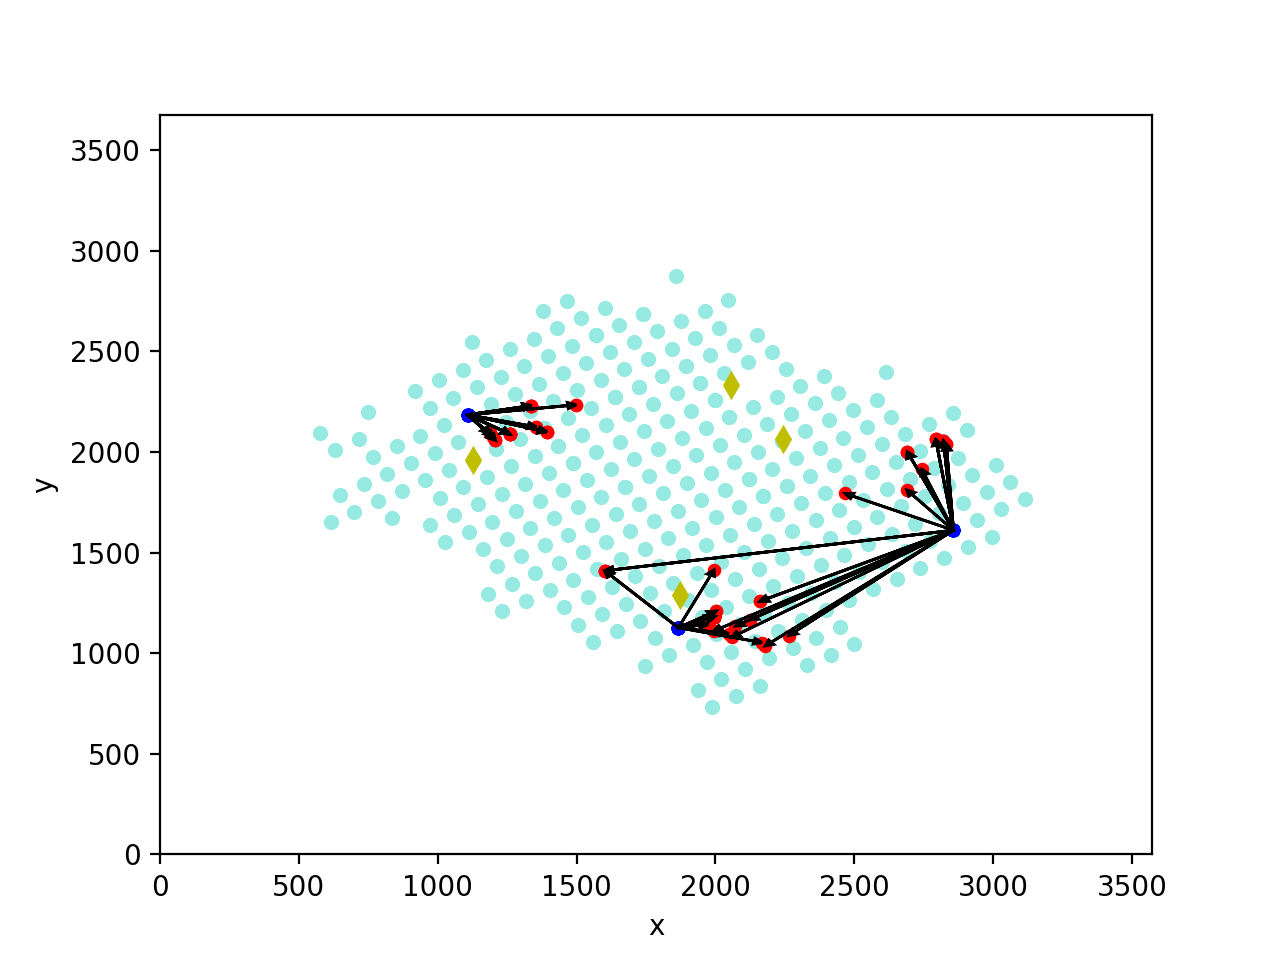

In [22]:
clf = KNeighborsRegressor(n_neighbors=5)
X_train, X_test, y_train, y_test = train_test_split(regre_data, regre_target, test_size=0.007)

X_test = np.array(X_test)
X_train = np.array(X_train)
y_test = np.array(y_test)

X_train = np.array([get_emission_means(X_train[i]) for i in range(len(X_train))])
    
y_test = np.array(flatten_list([[y_test[i]]*len(X_test[i]) for i in range(len(y_test))]))
X_test = np.array([e for i in range(len(X_test)) for e in X_test[i]])

clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

show_prediction_map_examples(predictions, y_test)